# Numerical determination of $\sigma_0$

In [327]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from scipy.signal import argrelextrema
import math
import numpy as np
import matplotlib.pyplot as plt
import sys
import os,glob
import yaml
from chainconsumer import ChainConsumer
from scipy.special import gamma
from scipy.optimize import fsolve
from scipy.interpolate import interp1d  
import pandas as pd
import matplotlib.ticker as ticker

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size']=13
plt.rcParams['font.family']='stix'
plt.rcParams['text.usetex']=True
plt.rcParams['figure.figsize']= (6.5,4)
plt.rcParams['figure.dpi']=150

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



In [328]:
masses_test = [1e-4,1e-3,1e-2,1e-1,1.,10.]
smallSigs = np.logspace(-20,-30,100)
cmapSigs = np.logspace(-20,-30,246)
largeSigs = np.logspace(-10,-30,30)

## IC generation

In [329]:
def make_inis(ini_base_file='class/inis/dmeff_base.ini',
              base_inis_path='class/inis/',
              class_runner_path = 'class/',
              npow=0,
              masses=masses_test,
              sigmas=smallSigs,
              output_path='pk_output',
              sh_file='class/run_classes.sh'):
    
    sh_file = class_runner_path+'run_classes.sh'

    fin =  open(ini_base_file, 'r')
    base_content = fin.read()
    fin.close()
    
    fout_sh = open(sh_file, 'w')

    for m in masses:
        if m<1:
            sigmas = smallSigs
        else:
            sigmas = largeSigs
            
        for sigma in smallSigs:
            filename = 'n{}_m{}_s{}.ini'.format(npow,m,sigma)
            fout_sh.write('./class ' + 'inis/{}\n'.format(filename))

            fout = open(base_inis_path + filename, 'w')
            fout.write(base_content)
            fout.write('\n')

            npow_line = 'npow_dmeff = {}\n'.format(npow)
            fout.write(npow_line)
            m_line = 'm_dmeff = {}\n'.format(m)
            fout.write(m_line)
            sigma_line = 'sigma_dmeff = {}\n'.format(sigma)
            fout.write(sigma_line)
            if npow<0:
                vel_line = 'Vrel_dmeff_rate = 30\n' #sets to DBK case.
                fout.write(vel_line)
            root_line = 'root = {}/n{}_m{}_s{}_\n'.format(output_path,npow,m,sigma)
            fout.write(root_line)
            
    fout_sh.close()

In [6]:
make_inis(npow=0)

## Relevant functions

In [7]:
def calculate_kcuts(npow=0, m=1e-3, z='z1',sigmas=smallSigs,
           pk_root='class/pk_output/', upper_cut=66, lower_cut=1, reduction_factor=0.75):
    
    data0 = np.loadtxt(pk_root + 'lcdm_{}_pk.dat'.format(z))
    ks = data0[:,0]
    pk0 = data0[:,1]
    khms = []
    ss = []
    
    if m<1:
        sigmas = smallSigs
    else:
        sigmas = largeSigs
        
    for i,sigma in enumerate(sigmas):
        filename = pk_root + 'n{}_m{}_s{}_{}_pk.dat'.format(npow,m,sigma,z)
        try:
            data = np.loadtxt(filename)
        except:
            continue
        pk = data[:,1]
        ind = (np.abs(np.abs((pk0-pk)/pk0) - reduction_factor)).argmin()
        if ks[ind]>upper_cut or ks[ind]<lower_cut:
            continue
        khms.append(ks[ind])
        ss.append(sigmas[i])
    
    try:
        p = np.polyfit(np.log10(ss), np.log10(khms), 1)
    except:
        return -1
    
    return np.array(ss),np.array(khms),p

In [8]:
def fit_fun(x,p):
    pp = p[0]*np.log10(x) + p[1]
    return np.power(10,pp)

In [9]:
def sigma0_limit(kcut, masses=masses_test,
                npow=0, z=0,reduction_factor=0.25,
                ymax=1e-26,ymin=1e-31,plot_ks=True):
    
    masses = np.array(masses)
    sigmas = np.zeros(len(masses))

    for i,m in enumerate(masses):
        ks_filename = 'data/ks_{}_z{}_n{}_m{}.txt'.format(reduction_factor,z,npow,m)
        np.loadtxt(ks_filename)
        data = np.loadtxt(ks_filename)
        ss = data[:,0]
        ks = data[:,1]
        p = np.polyfit(np.log10(ks), np.log10(ss), 1)
        sigmas[i] = fit_fun(kcut,p)
                  
    return masses,sigmas

In [431]:
def findLocalMins(arr):
    mins = []
    i=0
    while i < len(arr):
        try:
            if (arr[i-3]-arr[i])>0.01 and (arr[i+3]-arr[i])>0.01:
                mins.append(i)
                i+=3
            i+=1
        except:
            i+=1
            continue
         
    return mins

In [432]:
def findLocalMaxs(arr):
    maxs = []
    i=0
    while i < len(arr):
        try:
            if (arr[i]-arr[i-3])>0.01 and (arr[i]-arr[i+3])>0.01:
                maxs.append(i)
                i+=3
            i+=1
        except:
            i+=1
            continue
                
    return maxs

In [471]:
def show_pk(npow=0,m=0.0001,sigmas=smallSigs,z='z1',
           pk_root='class/pk_output/',
            filename=None,lcdm_filename='lcdm_z1_pk.dat',label='',
           f=None,ax=None,xmin=0,xmax=20,ymin=-1.0,ymax=1e3,
           show_kcut=True,pfit=None, relative=True,boost_factor=1.):
    
    data0 = np.loadtxt(pk_root + lcdm_filename)
    ks = data0[:,0]
    pk0 = data0[:,1]

    if filename is None:
        for i,sigma in enumerate(sigmas):
            if i%18!=0 or i>60:
                continue
            filename = pk_root + 'n{}_m{}_s{}_{}_pk.dat'.format(npow,m,sigma,z)
            np.loadtxt(filename)
            data = np.loadtxt(filename)
            pk = data[:,1]
            
            a = pk/pk0
            mins = findLocalMins(a)
            maxs = findLocalMaxs(a)
            
            if(i==0):
                ls = "-"
            elif(i==20):
                ls = "-."
            elif(i==40):
                ls = "--"
            elif(i==60):
                ls = ":"
            lbl = "$\sigma_0=$"+str('{:.1e}'.format(float(sigma)))+r"$\textrm{cm}^2$"
            
            plt.plot(ks,(pk)/pk0,linewidth=8,linestyle='-',color=(math.sqrt((i+1.))/10,1-math.sqrt((i+1.))/10,1-math.sqrt((i+1.))/10),label=lbl)
            try:
                ind = int((mins[1]-maxs[0])/1.25)
                print('{:.1e}'.format(float(sigma)), ks[maxs[0]+ind])
#                 plt.axvline(x=ks[maxs[0]+ind],linewidth=3)
            except:
                continue
                
            plt.xscale('log')

    plt.xlabel('k [1/Mpc]',fontsize=30)
    plt.ylabel('P(k) residual',fontsize=30)
    plt.xlim(1e-5,1e5)
    plt.xticks(fontsize=23)
    plt.yticks(fontsize=23)
    plt.xlim(1e-1,1e2)
    plt.legend(fontsize=58)
    plt.ylabel(r"$P(k)_{IDM}/P(k)_{CDM}$", fontsize=80,labelpad=45)
    plt.xlabel(r"k [1/Mpc]", fontsize=80, labelpad=30)
    plt.tick_params(labelsize=70)
    plt.savefig("pk{}some.pdf".format(npow),dpi=1000)

In [468]:
def dtk(npow=0,m=0.0001,sigmas=smallSigs,z='z1',
       pk_root='class/pk_output/',
        filename=None,lcdm_filename='lcdm_z1_pk.dat',label='',
       f=None,ax=None,xmin=0,xmax=20,ymin=-1.0,ymax=1e3,
       show_kcut=True,pfit=None, relative=True,boost_factor=1.):
    
    data0 = np.loadtxt(pk_root + lcdm_filename)
    ks = data0[:,0]
    pk0 = data0[:,1]
    
    if filename is None:
        for i,sigma in enumerate(sigmas):
            if i == 0:
                continue
                
            filename = pk_root + 'n{}_m{}_s{}_{}_tk.dat'.format(npow,m,sigma,z)
            np.loadtxt(filename)
            data = np.loadtxt(filename)
            
            ks = data[:,0]
            dg = data[:,1]
            db = data[:,2]
            ddmeff = data[:,3]
            dur = data[:,4]
            dtot = data[:,5]
            
            df = pd.DataFrame({'k':ks,'dg':dg,'db':db,'ddmeff':ddmeff,'dtot':dtot})
    return df

---

('1.0e-20', 3.389191365541)
('1.5e-22', 10.71756414128)
('2.3e-24', 33.89191365541)


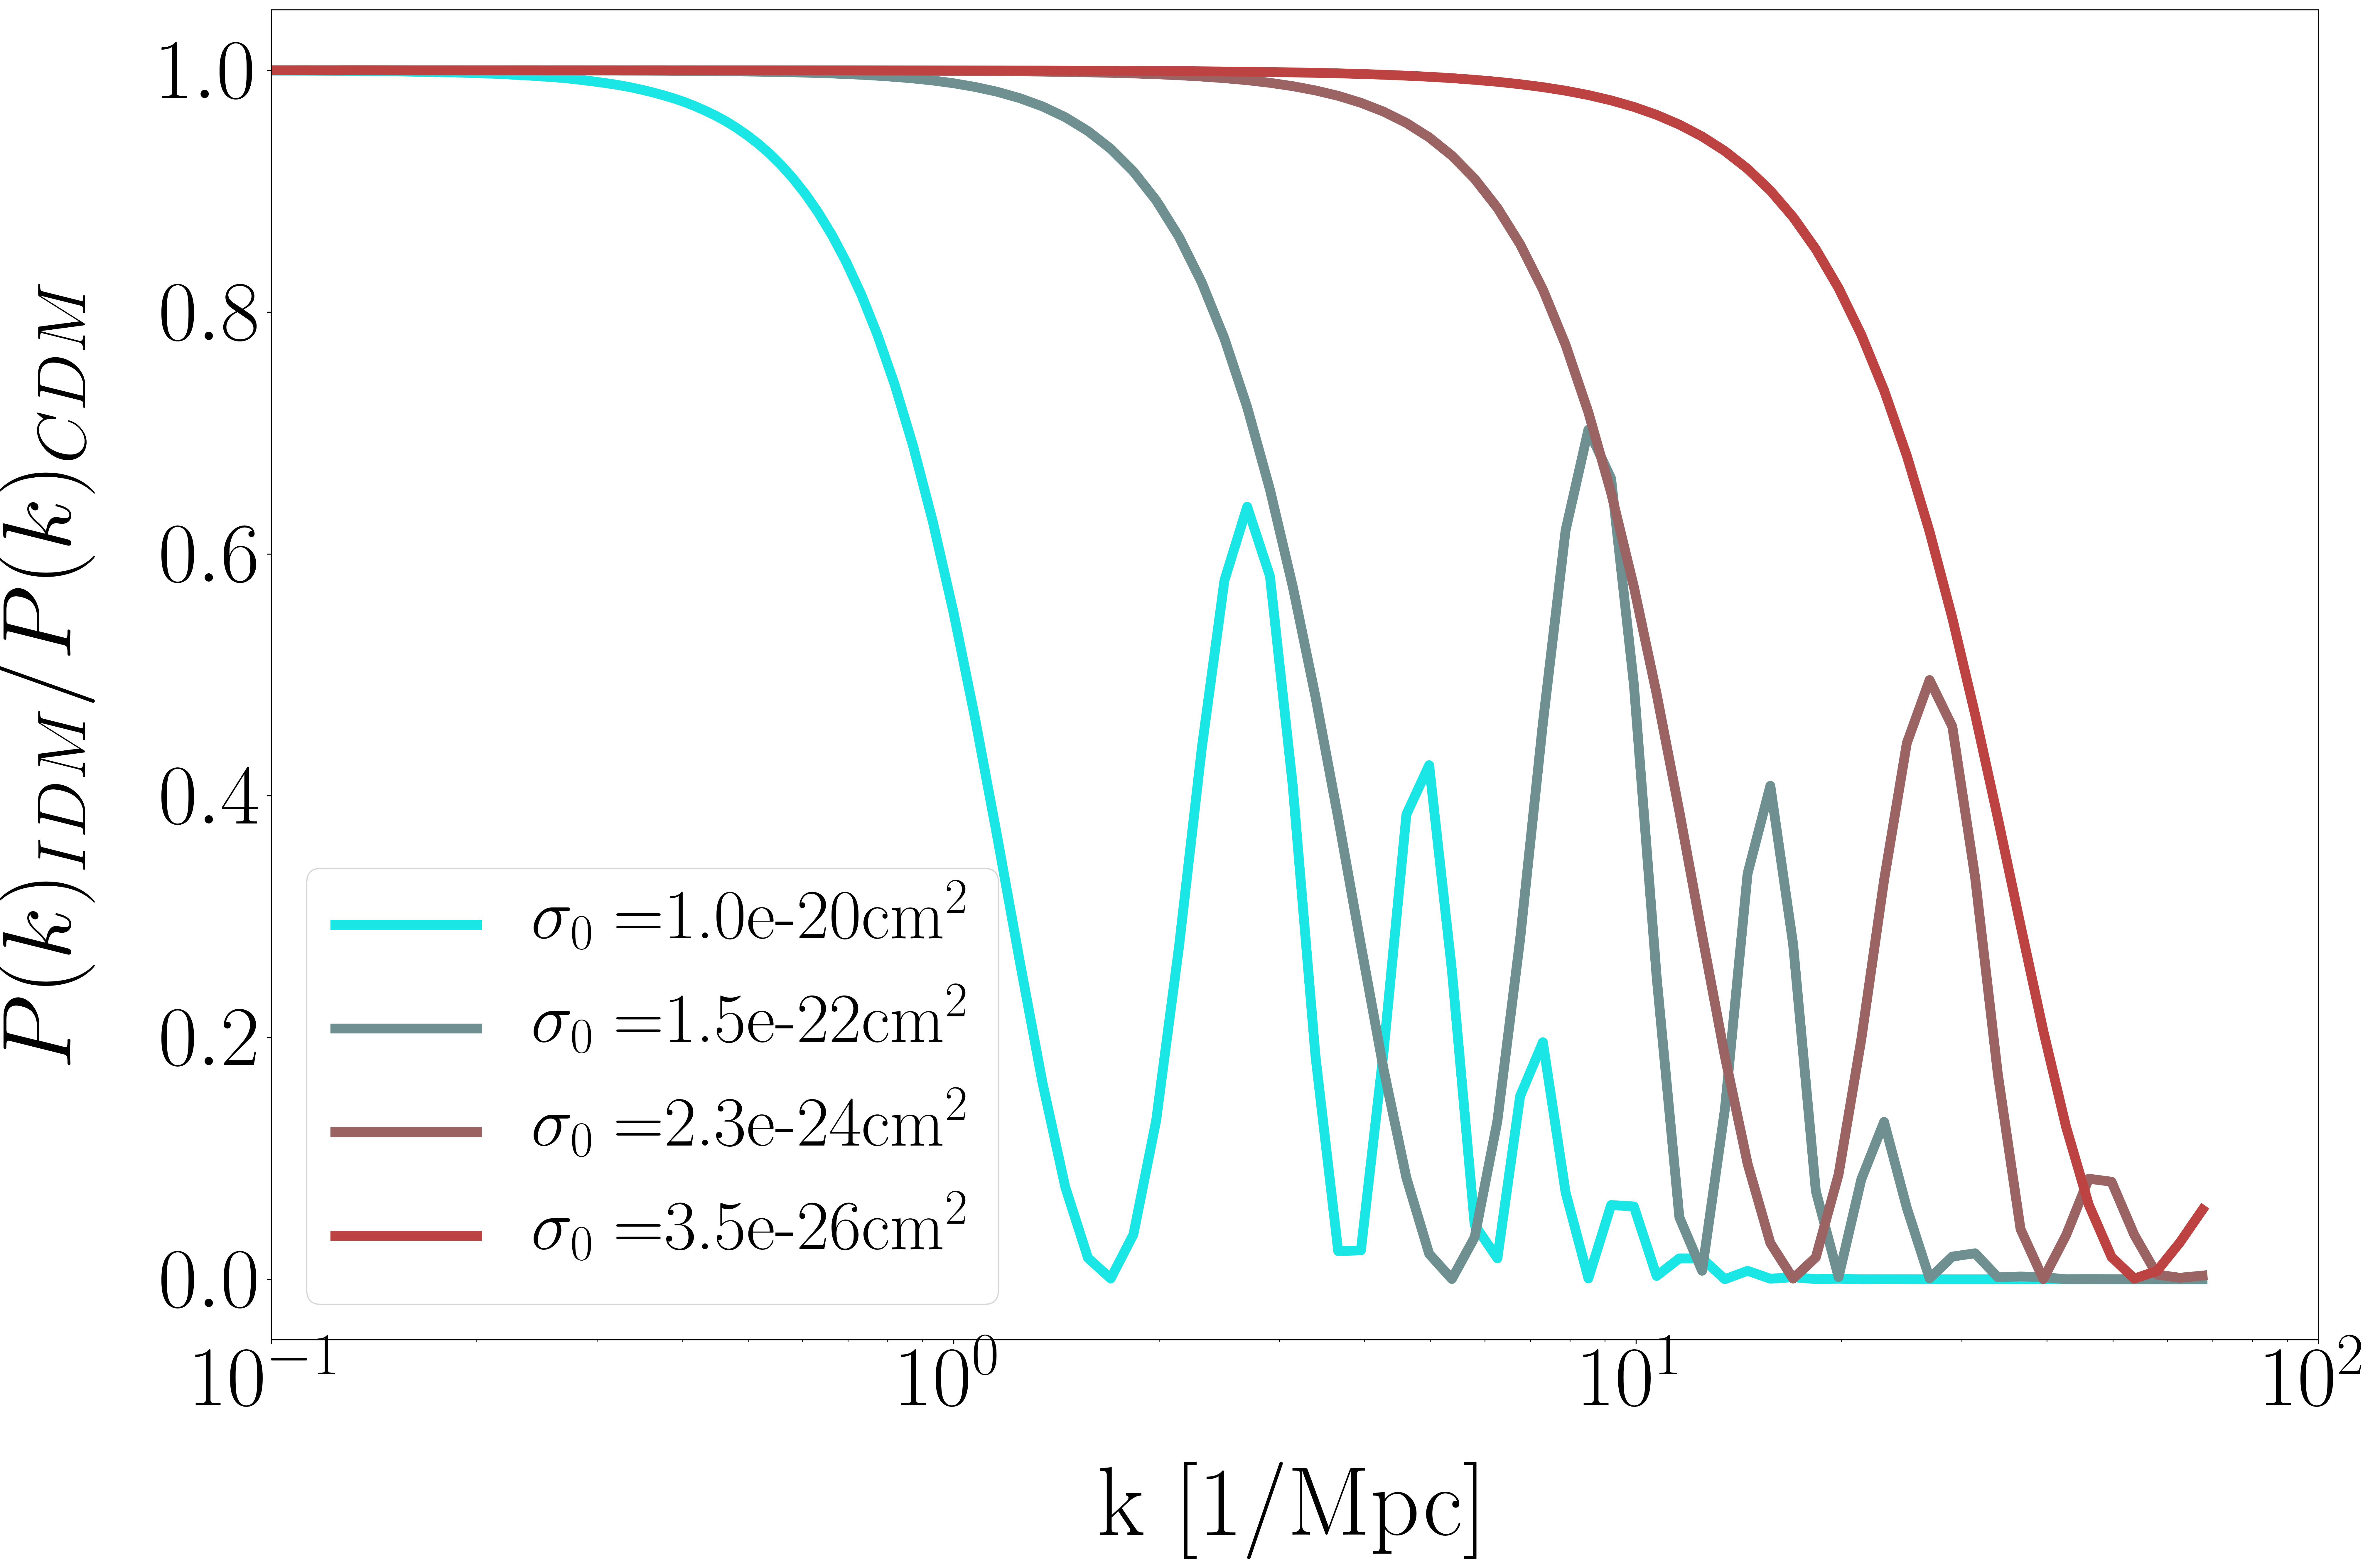

In [472]:
plt.figure(figsize=(30,20))    
# show_pk(npow=0,label="n=0")
# show_pk(npow=2,label="n=2")
show_pk(npow=4,label="n=4")
# show_pk(npow=6,label="n=6")

---

In [13]:
df = dtk(npow=2)
df[df.k>35]

7.924828983539186e-21


,db,ddmeff,dg,dtot,k
237,-0.003451,-0.003485,2.128647e-11,-0.003479,36.595647
238,-0.000591,-0.000648,1.821117e-11,-0.000639,39.515070
239,-0.001031,-0.001047,1.562503e-11,-0.001044,42.667391
240,0.002264,0.002182,1.336144e-11,0.002194,46.071189
241,-0.003430,-0.003289,1.151636e-11,-0.003310,49.746526
242,-0.002723,-0.002601,9.871319e-12,-0.002619,53.715063
243,0.002194,0.002054,8.430003e-12,0.002075,58.000191
244,0.001792,0.001641,7.232797e-12,0.001664,62.627166
245,-0.001599,-0.001501,6.222088e-12,-0.001516,67.623258


---

In [14]:
npow_=0

In [15]:
for m in masses_test:
    if calculate_kcuts(npow=npow_, m=m, z='z1') == -1:
        continue
    sigmas, kcuts, p = calculate_kcuts(npow=npow_, m=m, z='z1')

In [ ]:
sigmas_ref = np.logspace(-10,-30,1000)
for m in masses_test:
    ks_filename = 'data/ks_0.25_z0_n{}_m{}.txt'.format(npow_,m)
    if calculate_kcuts(npow=npow_, m=m, z='z1') == -1:
        continue
    sigmas, kcuts, p = calculate_kcuts(npow=npow_, m=m, z='z1')
    ks = fit_fun(sigmas_ref,p)
    np.savetxt(ks_filename, np.vstack((sigmas_ref, ks)).T)

In [ ]:
masses0,sigmas0=sigma0_limit(kcut=36,npow=0)
masses2,sigmas2=sigma0_limit(kcut=36,npow=2)
masses4,sigmas4=sigma0_limit(kcut=36,npow=4)
masses6,sigmas6=sigma0_limit(kcut=36,npow=6)

In [ ]:
plt.figure(figsize=(15,10))

# plt.loglog(masses6,sigmas6, label="n=6",linewidth=5,linestyle=':')
# plt.loglog(masses4,sigmas4, label="n=4",linewidth=5,linestyle='-.')
plt.loglog(masses2,sigmas2, label="n=2",linewidth=5,linestyle='--')
# plt.loglog(masses0,sigmas0, label="n=0",linewidth=5)

plt.ylabel(r"Cross section $\sigma_0$ [$cm^2$]", fontsize=40)
plt.xlabel(r"Dark matter mass $m_x$ [GeV]", fontsize=40)
plt.legend(fontsize=30)
plt.tick_params(labelsize=25)
plt.ylim(1e-30,1e-11)

plt.savefig("numerical.png")